In [6]:
import pandas as pd
import re
import sqlparse

db = "cockroachdb"
db1 = "duckdb"
db2 = "sqlite"
db3 = "mysql"

results_df_cockroach = pd.read_csv(f"{db}_output/{db}_results.csv")
results_df_duck = pd.read_csv(f"{db1}_output/{db1}_results.csv")
results_df2_sqlite = pd.read_csv(f"{db2}_output/{db2}_results.csv")
results_df3_mysql = pd.read_csv(f"{db3}_output/{db3}_results.csv")

In [7]:
testcase_mapping = results_df_cockroach[['TESTFILE_INDEX', 'TESTFILE_PATH']].drop_duplicates()
#results_df_cockroach = results_df_cockroach.set_index(['TESTFILE_INDEX','TESTCASE_INDEX'])
#results_df_duck = results_df_duck.set_index(['TESTFILE_INDEX','TESTCASE_INDEX'])
#results_df2_sqlite = results_df2_sqlite.set_index(['TESTFILE_INDEX','TESTCASE_INDEX'])
#results_df3_mysql =results_df3_mysql.set_index(['TESTFILE_INDEX','TESTCASE_INDEX'])
drop_cockroach_errors = results_df_cockroach[results_df_cockroach.IS_ERROR == True].index

In [34]:
results_df3_mysql.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10856 entries, 0 to 10855
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       10856 non-null  int64  
 1   DBMS_NAME        10856 non-null  object 
 2   TESTFILE_INDEX   10856 non-null  int64  
 3   TESTFILE_PATH    10856 non-null  object 
 4   ORIGINAL_SUITE   0 non-null      float64
 5   TESTCASE_INDEX   10856 non-null  int64  
 6   SQL              10856 non-null  object 
 7   CASE_TYPE        10856 non-null  object 
 8   EXPECTED_RESULT  5678 non-null   object 
 9   ACTUAL_RESULT    10687 non-null  object 
 10  EXEC_TIME        10856 non-null  int64  
 11  DATE             10856 non-null  object 
 12  IS_ERROR         10856 non-null  bool   
 13  ERROR_MSG        10344 non-null  object 
 14  USER             10856 non-null  object 
 15  LOGS_INDEX       10856 non-null  int64  
dtypes: bool(1), float64(1), int64(5), object(9)
memory usage: 

In [9]:
cockroach = results_df_cockroach.drop(['Unnamed: 0','ORIGINAL_SUITE','DATE','TESTFILE_PATH'], axis =1).copy()
#cockroach = cockroach.drop(drop_cockroach_errors)
duck = results_df_duck.drop(['Unnamed: 0','ORIGINAL_SUITE','DATE','TESTFILE_PATH'], axis =1).copy()
#duck = duck.drop(drop_cockroach_errors, errors='ignore')
sqlite = results_df2_sqlite.drop(['Unnamed: 0','ORIGINAL_SUITE','DATE','TESTFILE_PATH'], axis =1).copy()
#sqlite = sqlite.drop(drop_cockroach_errors, errors='ignore')
mysql = results_df3_mysql.drop(['Unnamed: 0','ORIGINAL_SUITE','DATE','TESTFILE_PATH'], axis =1).copy()
#mysql = mysql.drop(drop_cockroach_errors, errors='ignore')

In [10]:
cols = ['TESTCASE_INDEX','TESTFILE_INDEX','SQL','CASE_TYPE','EXPECTED_RESULT', 'USER']
dummy = 'squality_nishita_3.14159'
cockroach = cockroach.fillna(dict(zip(cols, [dummy]*len(cols))))
dfc = cockroach.drop(columns = cols).drop(columns = ['DBMS_NAME'])
dfc.columns = 'cockroachdb_' + dfc.columns
dfc = pd.concat([dfc, cockroach[cols]], axis=1)

duck = duck.fillna(dict(zip(cols, [dummy]*len(cols))))
dfduck = duck.drop(columns = cols).drop(columns = ['DBMS_NAME'])
dfduck.columns = 'duckdb_' + dfduck.columns
dfduck = pd.concat([dfduck, duck[cols]], axis=1)

sqlite = sqlite.fillna(dict(zip(cols, [dummy]*len(cols))))
dfsqlite = sqlite.drop(columns = cols).drop(columns = ['DBMS_NAME'])
dfsqlite.columns = 'sqlite_' + dfsqlite.columns
dfsqlite = pd.concat([dfsqlite, sqlite[cols]], axis=1)

mysql = mysql.fillna(dict(zip(cols, [dummy]*len(cols))))
dfmysql = mysql.drop(columns = cols).drop(columns = ['DBMS_NAME'])
dfmysql.columns = 'mysql_' + dfmysql.columns
dfmysql = pd.concat([dfmysql, mysql[cols]], axis=1)



In [11]:
df = dfc.merge(dfduck, on=cols, how='outer').merge(dfsqlite, on=cols, how='outer').merge(dfmysql, on=cols, how='outer')

In [12]:
import numpy as np
df[cols] = df[cols].replace(dummy, np.nan)

In [13]:
df = df[['TESTCASE_INDEX', 'TESTFILE_INDEX', 'SQL',
       'CASE_TYPE', 'EXPECTED_RESULT', 'USER','cockroachdb_ACTUAL_RESULT', 'cockroachdb_EXEC_TIME',
       'cockroachdb_IS_ERROR', 'cockroachdb_ERROR_MSG',
       'cockroachdb_LOGS_INDEX', 'duckdb_ACTUAL_RESULT',
       'duckdb_EXEC_TIME', 'duckdb_IS_ERROR', 'duckdb_ERROR_MSG',
       'duckdb_LOGS_INDEX', 'sqlite_ACTUAL_RESULT', 'sqlite_EXEC_TIME',
       'sqlite_IS_ERROR', 'sqlite_ERROR_MSG', 'sqlite_LOGS_INDEX',
       'mysql_ACTUAL_RESULT', 'mysql_EXEC_TIME', 'mysql_IS_ERROR',
       'mysql_ERROR_MSG', 'mysql_LOGS_INDEX']]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14549 entries, 0 to 14548
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   TESTCASE_INDEX             14549 non-null  int64  
 1   TESTFILE_INDEX             14549 non-null  int64  
 2   SQL                        14549 non-null  object 
 3   CASE_TYPE                  14549 non-null  object 
 4   EXPECTED_RESULT            8603 non-null   object 
 5   USER                       14549 non-null  object 
 6   cockroachdb_ACTUAL_RESULT  12099 non-null  object 
 7   cockroachdb_EXEC_TIME      12517 non-null  float64
 8   cockroachdb_IS_ERROR       12517 non-null  object 
 9   cockroachdb_ERROR_MSG      8367 non-null   object 
 10  cockroachdb_LOGS_INDEX     12517 non-null  float64
 11  duckdb_ACTUAL_RESULT       12218 non-null  object 
 12  duckdb_EXEC_TIME           12464 non-null  float64
 13  duckdb_IS_ERROR            12464 non-null  obj

In [14]:
df_all_errors = df[(df['cockroachdb_IS_ERROR'] == False) & 
  (df['mysql_IS_ERROR'] == False) &
  (df['sqlite_IS_ERROR'] == False) &
  (df['duckdb_IS_ERROR'] == False)].copy()

In [15]:
df_duck_db = df[(df['cockroachdb_IS_ERROR'] == False) & 
  (df['mysql_IS_ERROR'] == False) &
  (df['sqlite_IS_ERROR'] == False) &
  (df['duckdb_IS_ERROR'] == True)].copy()
df_duck_db_statements = df_duck_db[(df_duck_db['CASE_TYPE'] == 'Statement')].copy()
df_duck_db_queries = df_duck_db[(df_duck_db['CASE_TYPE'] == 'Query')].copy()
print("Number of statements failing only in duckdb: ",len(df_duck_db_statements) )
print("Number of queries failing only in duckdb: ",len(df_duck_db_queries) )

df_error = df_duck_db.copy()
print("Total number of unique error messages: ", len(df_error['duckdb_ERROR_MSG'].unique()))
value_mismatch = df_error[df_error['duckdb_ERROR_MSG'] == 'Result MisMatch']
print("Total number of result mismatch ", len(value_mismatch))



Number of statements failing only in duckdb:  165
Number of queries failing only in duckdb:  24
Total number of unique error messages:  50
Total number of result mismatch  2


In [16]:
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

def print_all_value_mismatch(db: str, value_mismatch):
    x = len(value_mismatch)
    print(x)
    for i in range(0,x):
        process_result_mismatch(db, value_mismatch, i)
        
def process_result_mismatch(db: str, value_mismatch, index):
    #print(value_mismatch[['EXPECTED_RESULT', f'{db}_ACTUAL_RESULT', 'SQL']])
#todo: cluster these errors and try to find bugs
    sample = value_mismatch.iloc[index]
    temp_df = df[df['TESTFILE_INDEX'] == sample['TESTFILE_INDEX']]
    for sql in temp_df[
        (temp_df['CASE_TYPE'] == 'Statement') 
        #& temp_df['cockroachdb_IS_ERROR'] == False
        #& ( (temp_df[f'{db}_ERROR_MSG'].isnull()) | (temp_df[f'{db}_ERROR_MSG'] == 'None') )
                      ]['SQL']:
        if(sql.startswith("SELECT") == False):
            print(sql,";")
    
    
    print("-----------The SQL commands is:---------")
    print(sample.SQL)
    print("-----------The expected result is:---------")
    print(sample.EXPECTED_RESULT)
    print("-----------The actual result is:---------")
    print(sample[f"{db}_ACTUAL_RESULT"])
    print("\n\nIndexes")
    print(sample['TESTCASE_INDEX'])
    print(sample['TESTFILE_INDEX'], '\n')

print_all_value_mismatch("duckdb", value_mismatch)


2
CREATE TABLE abc (a INT PRIMARY KEY, b INT, c INT) ;
INSERT INTO abc VALUES (1, 2, 3) ;
TABLE abc.* ;
INSERT INTO abc VALUES (0, 1, 2) ;
CREATE TABLE kv (k CHAR PRIMARY KEY, v CHAR) ;
INSERT INTO kv (k) VALUES ('a') ;
CREATE TABLE kw ("from" INT PRIMARY KEY) ;
INSERT INTO kw VALUES (1) ;
CREATE TABLE xyzw (   x INT PRIMARY KEY,   y INT,   z INT,   w INT,   INDEX foo (z, y) ) ;
INSERT INTO xyzw VALUES (4, 5, 6, 7), (1, 2, 3, 4) ;
((SELECT a FROM t LIMIT 1)) LIMIT 1 ;
CREATE TABLE boolean_table (   id INTEGER PRIMARY KEY NOT NULL,   value BOOLEAN ) ;
INSERT INTO boolean_table (id, value) VALUES (1, NULL) ;
INSERT INTO abc VALUES (42, NULL, NULL) ;
CREATE TABLE MaxIntTest (a INT PRIMARY KEY) ;
INSERT INTO MaxIntTest VALUES (9223372036854775807) ;
CREATE TABLE a (x INT PRIMARY KEY, y INT) ;
INSERT INTO a VALUES (1, 10), (2, 20), (3, 30) ;
CREATE TABLE b (x INT, y INT) ;
 INSERT INTO b VALUES (1, 10), (2, 20), (3, 30) ;
CREATE TABLE c (n INT PRIMARY KEY, str STRING, INDEX str(str DESC)) ;

In [17]:
df_cockroach_db = df[(df['cockroachdb_IS_ERROR'] == True) & 
  (df['mysql_IS_ERROR'] == False) &
  (df['sqlite_IS_ERROR'] == False) &
  (df['duckdb_IS_ERROR'] == False)].copy()
df_cockroach_db_statements = df_cockroach_db[(df_cockroach_db['CASE_TYPE'] == 'Statement')].copy()
df_cockroach_db_queries = df_cockroach_db[(df_cockroach_db['CASE_TYPE'] == 'Query')].copy()
print("Number of statements failing in cockroach: ",len(df_cockroach_db_statements) )
print("Number of queries failing in cockroach: ",len(df_cockroach_db_queries) )

df_error = df_cockroach_db.copy()
print("Total number of unique error messages: ", len(df_error['cockroachdb_ERROR_MSG'].unique()))
value_mismatch = df_error[df_error['cockroachdb_ERROR_MSG'] == 'Result MisMatch']
print("Total number of result mismatch ", len(value_mismatch))

testcase_mapping[testcase_mapping.TESTFILE_INDEX == 35]
df_error['cockroachdb_ERROR_MSG'].unique()

Number of statements failing in cockroach:  105
Number of queries failing in cockroach:  2
Total number of unique error messages:  2
Total number of result mismatch  2


array(['None', 'Result MisMatch'], dtype=object)

In [18]:
df_mysql_db = df[(df['cockroachdb_IS_ERROR'] == False) & 
  (df['mysql_IS_ERROR'] == True) &
  (df['sqlite_IS_ERROR'] == False) &
  (df['duckdb_IS_ERROR'] == False)].copy()
df_mysql_statements = df_mysql_db[(df_mysql_db['CASE_TYPE'] == 'Statement')].copy()
df_mysql_queries = df_mysql_db[(df_mysql_db['CASE_TYPE'] == 'Query')].copy()
print("Number of statements failing in mysql: ",len(df_mysql_statements) )
print("Number of queries failing in mysql: ",len(df_mysql_queries) )

df_error = df_mysql_db.copy()
print("Total number of unique error messages: ", len(df_error['mysql_ERROR_MSG'].unique()))
value_mismatch = df_error[df_error['mysql_ERROR_MSG'] == 'Result MisMatch']
print("Total number of result mismatch ", len(value_mismatch))




Number of statements failing in mysql:  289
Number of queries failing in mysql:  124
Total number of unique error messages:  224
Total number of result mismatch  7


In [19]:
print_all_value_mismatch("mysql", value_mismatch)


7
CREATE TABLE kv (   k INT PRIMARY KEY,   v INT ) ;
UPDATE kv SET v = (SELECT (10, 11)) ;
UPDATE kv SET v = 3.2 ;
UPDATE kv SET (k, v) = (3, 3.2) ;
UPDATE kv SET (k, v) = (SELECT 3, 3.2) ;
UPDATE kv SET v = '3.2'::STRING ;
UPDATE kv SET (k, v) = (3, '3.2'::STRING) ;
UPDATE kv SET (k, v) = (SELECT 3, '3.2'::STRING) ;
INSERT INTO kv VALUES (1, 2), (3, 4), (5, 6), (7, 8) ;
UPDATE kv SET v = 9 WHERE k IN (1, 3) ;
UPDATE kv SET v = k + v ;
UPDATE kv SET m = 9 WHERE k IN (1, 3) ;
UPDATE kv SET kv.k = 9 ;
UPDATE kv SET k.* = 9 ;
UPDATE kv SET k.v = 9 ;
CREATE VIEW kview as SELECT k,v from kv ;
UPDATE kview SET v = 99 WHERE k IN (1, 3) ;
CREATE TABLE kv2 (   k CHAR PRIMARY KEY,   v CHAR,   UNIQUE INDEX a (v),   FAMILY (k),   FAMILY (v) ) ;
INSERT INTO kv2 VALUES ('a', 'b'), ('c', 'd'), ('e', 'f'), ('f', 'g') ;
UPDATE kv2 SET v = 'g' WHERE k IN ('a') ;
UPDATE kv2 SET v = 'i' WHERE k IN ('a') ;
UPDATE kv2 SET v = 'b' WHERE k IN ('a') ;
UPDATE ONLY kv2 SET v = 'h' WHERE k IN ('a') ;
UPDATE kv2 *

In [20]:
df_sqlite_db = df[(df['cockroachdb_IS_ERROR'] == False) & 
  (df['mysql_IS_ERROR'] == False) &
  (df['sqlite_IS_ERROR'] == True) &
  (df['duckdb_IS_ERROR'] == False)].copy()
df_sqlite_statements = df_sqlite_db[(df_sqlite_db['CASE_TYPE'] == 'Statement')].copy()
df_sqlite_queries = df_sqlite_db[(df_sqlite_db['CASE_TYPE'] == 'Query')].copy()
print("Number of statements failing in sqlite: ",len(df_sqlite_statements) )
print("Number of queries failing in sqlite: ",len(df_sqlite_queries) )

df_error = df_sqlite_db.copy()
print("Total number of unique error messages: ", len(df_error['sqlite_ERROR_MSG'].unique()))
value_mismatch = df_error[df_error['sqlite_ERROR_MSG'] == 'Result MisMatch']
print("Total number of result mismatch ", len(value_mismatch))



Number of statements failing in sqlite:  144
Number of queries failing in sqlite:  29
Total number of unique error messages:  28
Total number of result mismatch  5


In [21]:
df_all_db = df[(df['cockroachdb_IS_ERROR'] == False) & 
  (df['mysql_IS_ERROR'] == False) &
  (df['sqlite_IS_ERROR'] == False) &
  (df['duckdb_IS_ERROR'] == False)].copy()
df_all_db_statement = df_all_db[(df_all_db['CASE_TYPE'] == 'Statement')].copy()
df_all_db_queries = df_all_db[(df_all_db['CASE_TYPE'] == 'Query')].copy()
print("Number of statements failing in all: ",len(df_all_db_statement) )
print("Number of queries failing in all: ",len(df_all_db_queries) )

df_error = df_all_db



Number of statements failing in all:  1991
Number of queries failing in all:  181


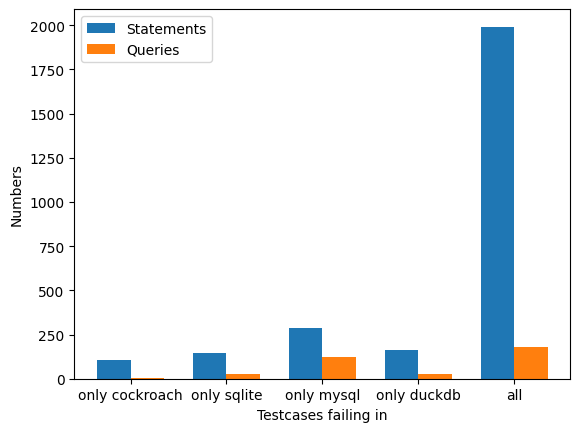

In [22]:
import matplotlib.pyplot as plt
import numpy as np

group1 = np.array([len(df_cockroach_db_statements), len(df_cockroach_db_queries)])
group2 = np.array([len(df_sqlite_statements), len(df_sqlite_queries)])
group3 = np.array([len(df_mysql_statements), len(df_mysql_queries)])
group4 = np.array([len(df_duck_db_statements), len(df_duck_db_queries)])
group5 = np.array([len(df_all_db_statement), len(df_all_db_queries)])


groups = np.concatenate((group1, group2, group3, group4, group5), axis=0).reshape((5, 2))


x = np.arange(5)
labels = np.array(['only cockroach', 'only sqlite', 'only mysql', 'only duckdb', 'all']).astype(str)

bar_width = 0.35
plt.bar(x - bar_width/2, groups[:, 0], width=bar_width, label='Statements')
plt.bar(x + bar_width/2, groups[:, 1], width=bar_width, label='Queries')

plt.xticks(x, labels)
plt.legend()
plt.xlabel('Testcases failing in')
plt.ylabel('Numbers')

plt.show()

In [23]:
def calculate_percentage_of_errors(dbms: str):
    errors = len(df[(df[f'{dbms}_IS_ERROR'] == True)])
    total_executed = len(df[~(df[f'{dbms}_EXEC_TIME']).isnull()])

    print(f"Percentage of errors in {dbms}: " , errors/total_executed * 100)
    
def calculate_percentage_of_successful_positive_testcases(dbms: str,  test_suite: str):
    success = df[(df[f'{dbms}_IS_ERROR'] == False)]
    positive_success = success[(success[f'{dbms}_ERROR_MSG'].isnull()) | (success[f'{dbms}_ERROR_MSG']=='None')]
    total_positive_testcase = len(
        df[
            ~(df[f'{dbms}_EXEC_TIME']).isnull() & 
            (df[f'{test_suite}_ERROR_MSG'].isnull()) | (df[f'{test_suite}_ERROR_MSG']=='None')
        ]
    )
    positive_success = len(positive_success)
    print(f"Percentage of success for positive test cases in {dbms}: " , positive_success/total_positive_testcase * 100)
    

calculate_percentage_of_errors("cockroachdb")
calculate_percentage_of_errors("duckdb")
calculate_percentage_of_errors("mysql")
calculate_percentage_of_errors("sqlite")

calculate_percentage_of_successful_positive_testcases("cockroachdb", "cockroachdb")
calculate_percentage_of_successful_positive_testcases("duckdb", "cockroachdb")
calculate_percentage_of_successful_positive_testcases("mysql", "cockroachdb")
calculate_percentage_of_successful_positive_testcases("sqlite", "cockroachdb")


Percentage of errors in cockroachdb:  13.46968123352241
Percentage of errors in duckdb:  64.50577663671375
Percentage of errors in mysql:  68.1190125276345
Percentage of errors in sqlite:  68.88835610964597
Percentage of success for positive test cases in cockroachdb:  97.70484770484771
Percentage of success for positive test cases in duckdb:  29.42872397223705
Percentage of success for positive test cases in mysql:  21.477737147773716
Percentage of success for positive test cases in sqlite:  23.2426060865838


In [24]:
DDL = ['CREATE', 'ALTER', 'DROP', 'TRUNCATE', 'COMMENT', 'RENAME']
DML = ['INSERT', 'UPDATE', 'DELETE', 'MERGE', 'UPSERT', 'REPLACE']
TCL = ['COMMIT', 'ROLLBACK', 'SAVEPOINT', 'RELEASE', 'SET', 'BEGIN']
DCL = ['GRANT', 'REVOKE']
DQL = ['SELECT']

def parse_sql(sql):
    statement = sqlparse.parse(sql)[0]
    typ = statement.get_type()
    sql_type = typ if "UNKNOWN" not in typ else str(statement.token_first())
    return sql_type

def get_statement_type(sql):
    statement = sqlparse.parse(sql)[0]
    typ = statement.get_type()
    if typ in DML :
        return "DML"
    elif typ in DCL:
        return "DCL"
    elif typ in TCL:
        return "TCL"
    elif typ in DDL:
        return "DDL"
    elif typ in DQL:
        return "DQL"
    else:
        return "UNKNOWN"

df['sql_type'] = df.apply(lambda row: parse_sql(row['SQL']), axis=1)
df['statement_type'] = df.apply(lambda row: get_statement_type(row['SQL']), axis=1)



<AxesSubplot: xlabel='statement_type'>

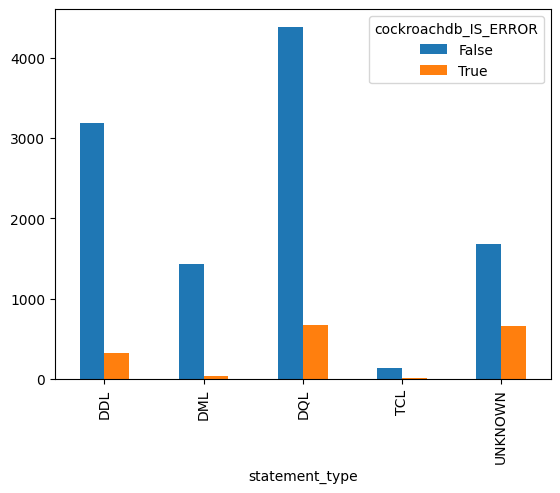

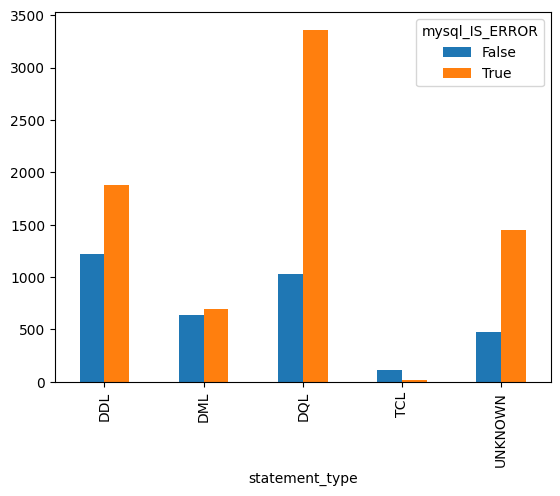

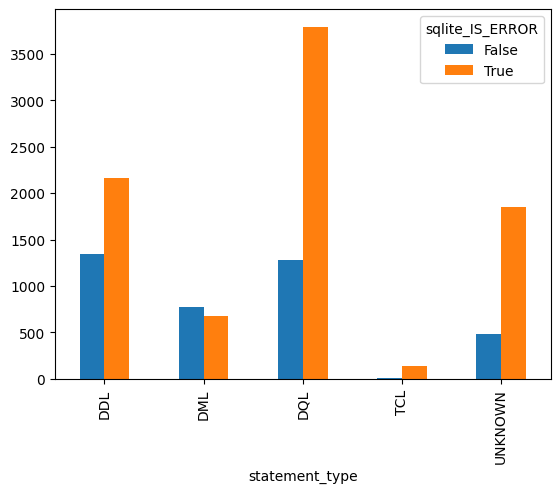

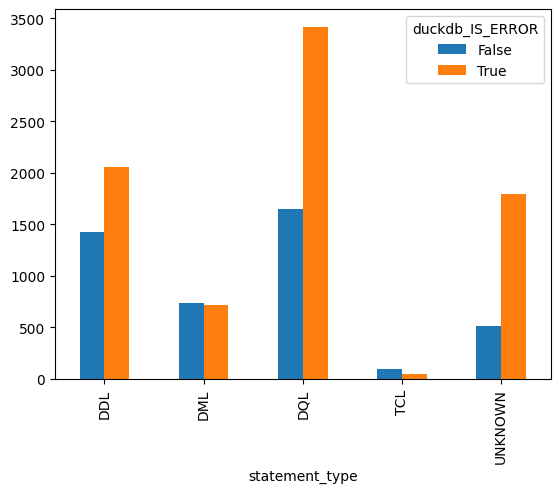

In [25]:

c = df[['statement_type', 'cockroachdb_IS_ERROR',]].groupby(['cockroachdb_IS_ERROR','statement_type']).value_counts()
df.groupby("statement_type").cockroachdb_IS_ERROR.value_counts().unstack(level=1).plot(kind='bar')
df.groupby("statement_type").mysql_IS_ERROR.value_counts().unstack(level=1).plot(kind='bar')
df.groupby("statement_type").sqlite_IS_ERROR.value_counts().unstack(level=1).plot(kind='bar')
df.groupby("statement_type").duckdb_IS_ERROR.value_counts().unstack(level=1).plot(kind='bar')


In [27]:
def find_sql_not_supported_by_dbms_only(dbms: str, df_success_cockroach) :
    #find sql that have success in cockroach but failed in dbms
    df_success_cockroach_fail_dbms = df_success_cockroach[df_success_cockroach[f'{dbms}_IS_ERROR'] == True ]
    #get their unique sql types
    unique_cockroach_success_sql_types = df_success_cockroach_fail_dbms.sql_type.unique()
    #some of these sql types may have passed also, so we need to subtract them
    testcase_on_dbms_with_sql_types = df[ 
        (
            ( (df[f'{dbms}_ERROR_MSG'].isnull()) | (df[f'{dbms}_ERROR_MSG'] == 'None') ) &
            (df[f'{dbms}_IS_ERROR'] == False) & 
            (df['sql_type'].isin(unique_cockroach_success_sql_types)) 
        ) 
        ]
    sql_types = np.array(testcase_on_dbms_with_sql_types.sql_type.unique())
    sql_not_supported_by_dbms = np.setdiff1d(unique_cockroach_success_sql_types,sql_types)
    sorted_types = list(sql_not_supported_by_dbms)
    sorted_types = sorted(sorted_types, key=lambda s: len(s.split()))
    print(f"Set of SQL queries not supported by {dbms}, but supported by cockroach: ")
    print('\n'.join(sorted_types))
    print("__________________________________________________")

def find_unsupported_sql(supported_by_dbms: str):
    df_success_cockroach = df[
          ( df[f'{supported_by_dbms}_IS_ERROR'] == False) & 
          ( (df[f'{supported_by_dbms}_ERROR_MSG'].isnull()) | (df[f'{supported_by_dbms}_ERROR_MSG']=='None' )) 
            ].copy()
    unique_cockroach_success_sql_types = np.array(df_success_cockroach.sql_type.unique())
    #print(unique_cockroach_success_sql_types)
    find_sql_not_supported_by_dbms_only("mysql", df_success_cockroach)
    find_sql_not_supported_by_dbms_only("sqlite", df_success_cockroach)
    find_sql_not_supported_by_dbms_only("duckdb", df_success_cockroach)
    find_sql_not_supported_by_dbms_only("cockroachdb", df_success_cockroach)
    #print(f"Set of SQL queries not supported by any dbms except {supported_by_dbms}: ", unique_cockroach_success_sql_types)

find_unsupported_sql("cockroachdb")


Set of SQL queries not supported by mysql, but supported by cockroach: 
ABORT
ANALYZE
CANCEL
COMMENT
DEALLOCATE
DISCARD
END
EXECUTE
EXPLAIN
EXPLAIN(DISTSQL)
PAUSE
PREPARE
RELEASE
RESET
RESUME
UNLISTEN
UPSERT
set
DISCARD SEQUENCES
EXPERIMENTAL SCRUB
PAUSE JOBS
REASSIGN OWNED
RESUME JOBS
(((SELECT a FROM t)))
(SELECT * FROM t1)
(SELECT NULL FROM t34524)
(SELECT a FROM t1)
(SELECT j FROM t1)
VALUES ((SELECT 1)), ((SELECT 2))
VALUES (1) EXCEPT VALUES (NULL)
VALUES (1) INTERSECT VALUES (NULL)
VALUES (1), (1), (2), (3)
VALUES (NULL) EXCEPT VALUES (1)
VALUES (NULL) EXCEPT VALUES (NULL)
VALUES (NULL) INTERSECT VALUES (1)
VALUES (NULL) INTERSECT VALUES (NULL)
VALUES (1) UNION ALL VALUES (NULL)
VALUES (NULL) UNION ALL VALUES (1)
VALUES (NULL) UNION ALL VALUES (NULL)
VALUES (1, 2, 1.0, 'string1'), (4, 3, 2.3, 'string2')
VALUES (length('a')), (1 + length('a')), (length('abc')), (length('ab') * 2)
(((SELECT a FROM t ORDER BY a DESC LIMIT 4)))
VALUES (1), (1), (1), (2), (2) EXCEPT VALUES (1), (3), (

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

def cluster_text(text):
    vectorizer = TfidfVectorizer(stop_words={'english'})
    X = vectorizer.fit_transform(text)

    import matplotlib.pyplot as plt
    from sklearn.cluster import KMeans
    Sum_of_squared_distances = []
    K = range(2,10)
    for k in K:
       km = KMeans(n_clusters=k, max_iter=200, n_init=10)
       km = km.fit(X)
       Sum_of_squared_distances.append(km.inertia_)
    plt.plot(K, Sum_of_squared_distances, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Sum_of_squared_distances')
    plt.title('Elbow Method For Optimal k')
    plt.show()

    true_k = 7
    model = KMeans(n_clusters=true_k, init='k-means++', max_iter=200, n_init=10)
    model.fit(X)

    labels=model.labels_
    clusters=pd.DataFrame(list(zip(text,labels)),columns=['title','cluster'])
    #print(clusters.sort_values(by=['cluster']))

    for i in range(true_k):
        print(clusters[clusters['cluster'] == i].head())
    
    print(clusters.groupby('cluster').nunique())
        
    return clusters

def cluster_errors(dbms:str, df):
    bug_rows = df[(df[f'{dbms}_IS_ERROR'] == True) ].copy()

    errors = bug_rows.dropna(subset = [f'{dbms}_ERROR_MSG'])[f'{dbms}_ERROR_MSG'].unique()

    print(errors.shape)
    errors = np.array(pd.Series(errors).str.replace( 'Parser Error:', ''))
    errors = np.array(pd.Series(errors).str.replace( 'Catalog Error:', ''))
    errors = np.array(pd.Series(errors).str.replace( 'Execution Failed:', ''))
    errors = np.array(pd.Series(errors).str.replace( "1064 \(42000\): You have an error in your SQL", ''))
    cluster_text(errors)
    #print(errors)

(1040,)


/var/folders/32/zv3nm8_12xb9ytd7vk7nnr6w0000gn/T/ipykernel_43295/569910358.py:46: FutureWarning: The default value of regex will change from True to False in a future version.
  errors = np.array(pd.Series(errors).str.replace( "1064 \(42000\): You have an error in your SQL", ''))


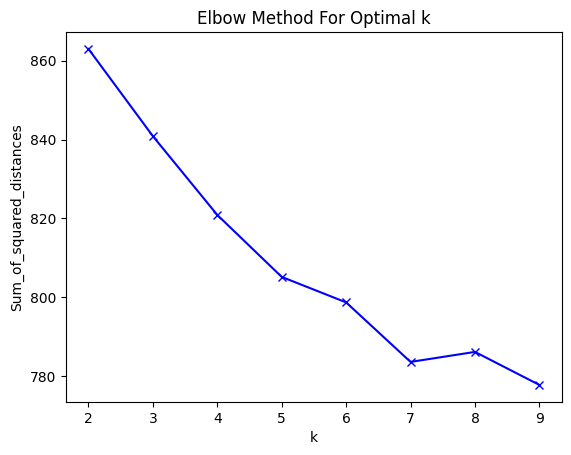

                                                title  cluster
25            no such table: SHOW RANGES FROM TABLE t        0
28        no such table: SHOW RANGES FROM INDEX t@idx        0
34   no such table: SHOW RANGES FROM TABLE "show r...        0
35   no such table: SHOW RANGES FROM INDEX "show r...        0
37       no such table: SHOW RANGES FROM TABLE """".t        0
                                title  cluster
0          near "INDEX": syntax error        1
2   near "EXPERIMENTAL": syntax error        1
5   near "EXPERIMENTAL": syntax error        1
8            near "SET": syntax error        1
9       near "DATABASE": syntax error        1
                             title  cluster
3            unknown database test        2
11         unknown database seq_db        2
29              unknown database d        2
30              unknown database e        2
32  unknown database "show ranges"        2
                            title  cluster
1                no such table: t

In [31]:
cluster_errors("sqlite", df)

(3995,)


/var/folders/32/zv3nm8_12xb9ytd7vk7nnr6w0000gn/T/ipykernel_43295/569910358.py:46: FutureWarning: The default value of regex will change from True to False in a future version.
  errors = np.array(pd.Series(errors).str.replace( "1064 \(42000\): You have an error in your SQL", ''))


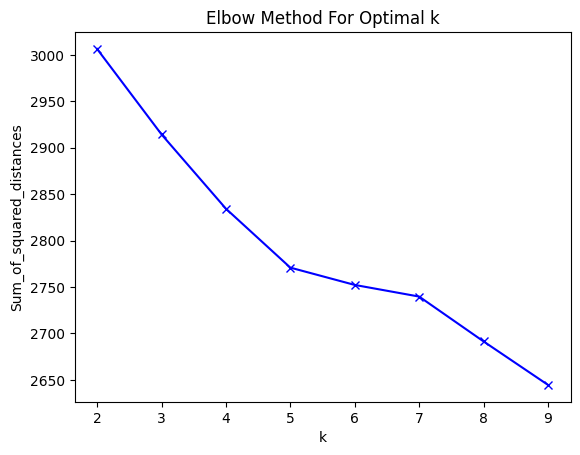

                                                title  cluster
14   syntax; check the manual that corresponds to ...        0
15   syntax; check the manual that corresponds to ...        0
24   syntax; check the manual that corresponds to ...        0
34   syntax; check the manual that corresponds to ...        0
35   syntax; check the manual that corresponds to ...        0
                                                title  cluster
70   syntax; check the manual that corresponds to ...        1
71   syntax; check the manual that corresponds to ...        1
72   syntax; check the manual that corresponds to ...        1
73   syntax; check the manual that corresponds to ...        1
75   syntax; check the manual that corresponds to ...        1
                                                 title  cluster
1           1146 (42S02): Table 'temp.t' doesn't exist        2
87     1146 (42S02): Table 'temp.rtable' doesn't exist        2
149   1146 (42S02): Table 'temp.geom_2d' doesn't exi

In [35]:
cluster_errors("mysql", df)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

